## Classification and Regression for Inofrmed Sampling (CRIS)
#### CRIS does initial to final state interpolation as well as informed sampling of parameter space. This is a demo showing the basic use of each of the main components of CRIS.

<br>

### What is the data set?

#### In this demo we consider a synthetic data set 'data/synth_data.dat'. For details see the source code: *'data/2D_analytic_class_regr.py'* and other included files.

The synthetic data is drawn from a single 2D analytic function:

$$ f_{\rm Regression}(x,y) = \frac{ \tanh(x^3 + y^2) }{ \sqrt{(x^2 + y^2)} + 0.9 } $$

The 2D classification geometry is based off the function to mimic what we might encounter in real data sets. Namley, regions where the classification has changed but regression output is smooth and vice versa.

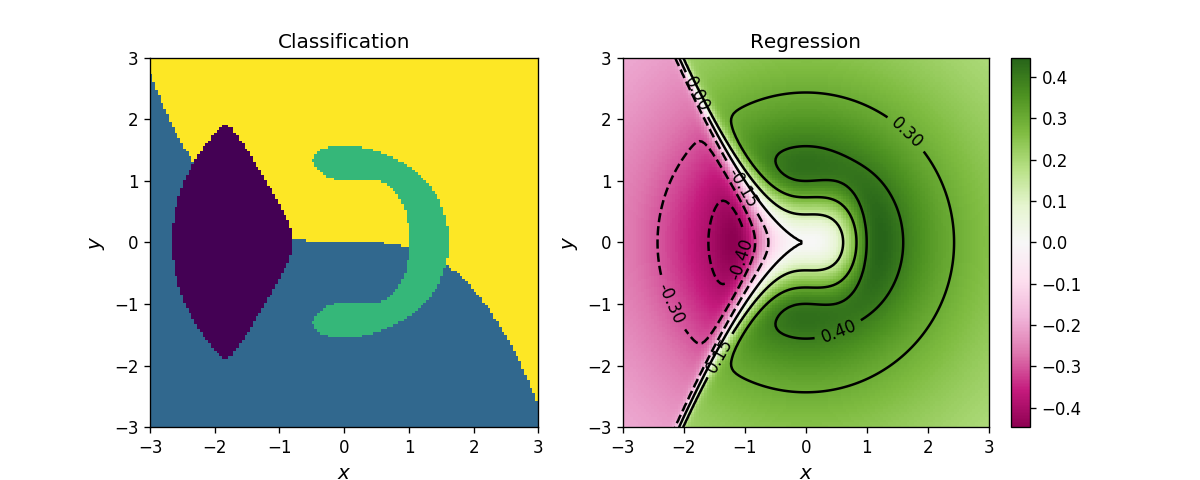

The points in 'data/synth_data.dat' are from a uniform grid of 10 points in each axis.

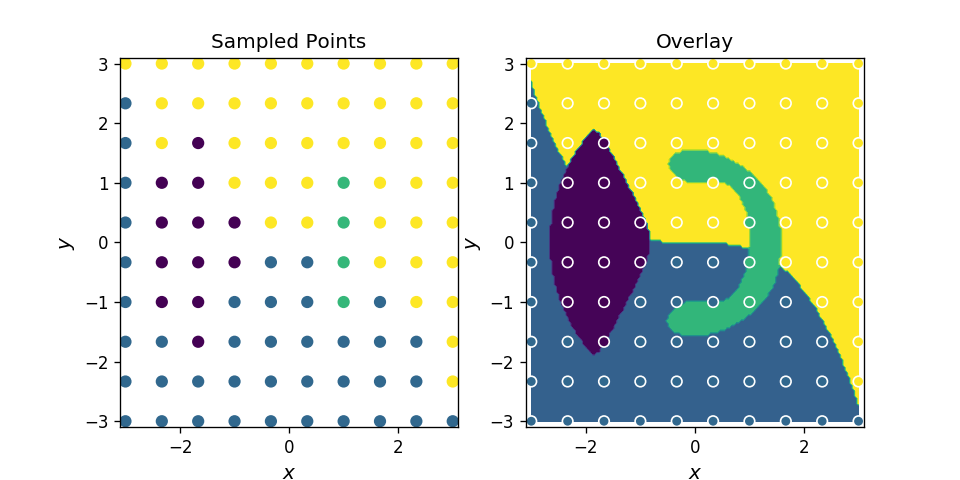

------

Now that we have seen the data, we will use it to test CRIS. First load everything we will need.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cris.data import TableData
from cris.classify import Classifier
from cris.regress import Regressor
from cris.sample import Sampler

Inheretance structure for the classes in CRIS:
- ***TableData*** holds all data pre-processed for the classifiers and regressors to train on
- ***Classifier*** and ***Regressor*** inheret TableData objects
- ***Sampler*** inherets both ***Classifier*** and or ***Regressor*** objects

In order to go from 'end to end', (e.g. given a data set, propose N new simulation points) there are methods in *cris.wrappers*. Since this process has many many free parameters, this tutorial serves as a guide for basic use of each module incase one is interested in changing any part.

---------

### TableData

To create a ***TableData*** object, a file path or Pandas DataFrame must be given. If using files, the names of inputs, outputs, and the classification column must be given.

In [5]:
files = ["data/synth_data.dat"] # can be more than one file
input_cols = ['input_1', 'input_2' ]
output_cols = ['class', 'output_1']
class_col_name = 'class'

my_kwargs = {"header": 0, 'delimiter': ','} # for reading in csv file

table_object = TableData( files, input_cols, output_cols, class_col_name, 
                          my_DataFrame = None, verbose=True, n_neighbors=[2], **my_kwargs)

# Alternatively, you can load the DataFrame directly:
# loaded_data = pd.read_csv("data/synth_data.dat")
# table_object = TableData( None, input_cols, output_cols, class_col_name, 
#                          my_DataFrame = loaded_data, verbose=True, n_neighbors=[2])

Reading in data from 1 file(s).
	'data/synth_data.dat'
Finished reading data.

Total number of data points: 100

Input columns: 2
Output columns: 2
Unique classes found in 'class': 4
Using default class colors.

Finding values to regress:
Num output(s) 	 Class Name
      1 	 'A'
      1 	 'B'
      1 	 'C'
      1 	 'D'

Calculate Average Distances & Average Percent Change
class: 'A'
	APC2_output_1
class: 'B'
	 -- 1 zeros in 'output_1'. Skipping p_change...
class: 'C'
	APC2_output_1
class: 'D'
	 -- 1 zeros in 'output_1'. Skipping p_change...
TableData Done in 0.03 seconds.


The verbose output tells you what TableData is doing when reading in the data. How many classes it has found, what outputs it thinks are valid data, and average percent change in an output quantitiy from its two nearest neighbors in input space.

###### Some other methods of interest in TableData

In [10]:
#table_object.get_all_class_data()
#table_object.get_all_regr_data()
#table_object.get_binary_mapping_per_class()
#table_object.get_data()
#table_object.get_info()
#table_object.info()

***

### Classifier

Now that we have created a ***TableData*** object, we can pass it along to the ***Classifier*** and ***Regressor***. The data structure for the classifier is fairly straight foward. All trained classifiers are stored in nested dictionaries. The outermost key being the method you used to train (e.g. RBF). Then the next key is simply the class which maps to an instance of whatever classification algorithm was used.  

In [9]:
classifier_obj = Classifier( table_object )

# train binary classifiers on all the data using:
# - Radial Basis Function (scipy)
# - LinearNDInterpolator (scipy)
# - Gaussian Process Classification (sci-kit learn)
classifier_obj.train_everything( ['rbf', 'linear', 'gp'], verbose=False)

Now that we have trained the classification algorithms, we can query points and get the probability that a point is in a given class. Below we will generate 10 random points and then ask our trained interpolator to return the 'probability' for each class.

In [17]:
test_points = np.random.uniform( low=-3, high=3, size=(10,2) )

probs, where_not_nan = classifier_obj.return_probs( 'lin', test_points, verbose=True)
print(probs)

Nans omitted: 0
[[0.         1.         0.         0.        ]
 [0.         0.         0.         1.        ]
 [0.         0.43528968 0.         0.56471032]
 [0.         0.         0.         1.        ]
 [0.         1.         0.         0.        ]
 [0.79874931 0.20125069 0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.         0.         0.         1.        ]
 [0.         1.         0.         0.        ]
 [0.         0.29737847 0.70262153 0.        ]]


The above matrix is $N_{\rm points} \times N_{\rm classes}$. For a given row, the numerical value corresponds to the 'probability' that the query is in each of the possible classes.

In [19]:
# What if we query points outside the domain? 
# For LinearNDInterpolator, a nan is returned which is where where_not_nan
# is a standard output for this function.
# We will see later on more handling of nans as we progress further.
probs, where_not_nan = classifier_obj.return_probs( 'lin', np.array([[-4,4]]), 
                                                    verbose=True)
print(probs)

Nans omitted: 1
[[0]]


###### Some other methods of interest in Classifier

In [20]:
#classifier_obj.get_rnd_test_inputs()
#classifier_obj.train()
#classifier_obj.get_class_predictions()
#classifier_obj.cross_validate()

-----------
### Regressor

Now we will play with the ***Regressor***. Now data structure has one more layer of complexity. Not only do we have different classes, but each class can have unique regression outputs. The nested dictionaries are organized by regression algorithm used (e.g. RBF), then classification (e.g "A"), and then the different outputs (e.g. "output_1", "output_2", etc.). This is illustrated in the example below.

In [21]:
regressor_obj = Regressor( table_object )

# None: train on all columns in classes "A" and "C" (assuming they have the same outputs)
regressor_obj.train("rbf", ["A","C"], None, verbose=True)

# automatically generate query points within the original range of training data
test_points_rgr = regressor_obj.get_rnd_test_inputs("A", 5)

preds = regressor_obj.get_predictions(["rbf"], 
                                      ["A", "C"], 
                                      ["output_1"], 
                                       test_points_rgr )
print( preds )

	 Training on all 2 columns in 'A'...
--- Fit RBF ---
A: output_1 - 12 training points
A: APC2_output_1 - 12 training points
C: output_1 - 4 training points
C: APC2_output_1 - 4 training points
--- Done in 0.06 seconds. ---
	dict loc: RBF, A, output_1,
	dict loc: RBF, A, APC2_output_1,
	dict loc: RBF, C, output_1,
	dict loc: RBF, C, APC2_output_1,
	EXIT TRAIN

{'RBF': {'A': {'output_1': array([-0.27435587, -0.32765857, -0.34821039, -0.32951164, -0.36547836])}, 'C': {'output_1': array([1.19395024, 0.86296385, 0.85017869, 1.06072569, 0.98667705])}}}


Notice that 'preds' is also a nested dictionary setup in the same way as the trained regression objects. First the interpoaltor, then the class, and finall the output mapping to the function values from regression.

****

### Sampler

Now that a ***Classifier*** and ***Regressor*** have been created, then can be passed to the sampler. The sampling algorithm is a PTMCMC that explores parameter space and is *supposed* to explore regions of interest. We have decided that regions of interest in the context of using simulation data are regions where there is a change in classification and where output variables are changing quickly (e.g. a change of output by 50% between two simulations).

For this to work, a target distribution must be constructed. I currently have implemented the following:

$$ f_{\rm target}(\mathbf{x}_{\rm inputs}) = \big(1 - \max[P_{\rm class}(\mathbf{x})]\big) +
 \max[<{\rm \% change}( {\rm class},N_{\rm neighbors})>]$$


In the near future I want it to be:

$$ f_{\rm target}(\mathbf{x}_{\rm inputs}) = \big(1 - \max[P_{\rm class}(\mathbf{x})]\big) +
A_1 \log\left( A_2 * \max[<{\rm \% change}( {\rm class},N_{\rm neighbors})>] + 1 \right)$$

The additional constants of multiplication and log will allow proper scaling of the average % change in output variables. 


In either case, we tell the PTMCMC function what method to use by passing it directly. This allows other target distributions to be tested and implemented. This method should generally be a class method as the data being accessed is instance specific.

In [23]:
sampler_obj = Sampler( classifier = classifier_obj, regressor= regressor_obj )

# Here is an example of a single MCMC run.
# Notice that we are using only the classification in the target distribution, no regression
steps, acc, rej = sampler_obj.run_MCMC(20, 0.5, [[0,0]], 
                                       sampler_obj.classifier_target_dist, 'rbf'  )
print( steps, acc, rej )

[[ 0.          0.        ]
 [ 0.50205417 -0.34155443]
 [ 1.02519917 -1.07407146]
 [ 0.61310844 -0.90197453]
 [ 0.8156079  -1.26932767]
 [ 1.24736747 -0.37821429]
 [ 1.50374538 -0.40397502]
 [ 1.24285396  0.23506658]
 [ 0.71815613  0.84356384]] 8 12


Now we will run a PTMCMC. At the end, trace plots are generated, showing the locations of the walkers in each axis as a function of step (time). Notice that the highest temperature chain takes more steps compared to the lowest temperature chain.

Num chains: 9
Temperatures: [30.          9.65489385  4.5341756   2.73946374  1.95783928  1.56501327
  1.34796521  1.22026023  1.        ]

num_acc/total: Tmax 0.7939, Tmin 0.4438, loop # 832, |====================>|100.0%
Length of chains: 
[2817 2678 2521 2408 2231 2151 2134 2002 1942]
Finished in 29.18 seconds, 0.49 minutes.


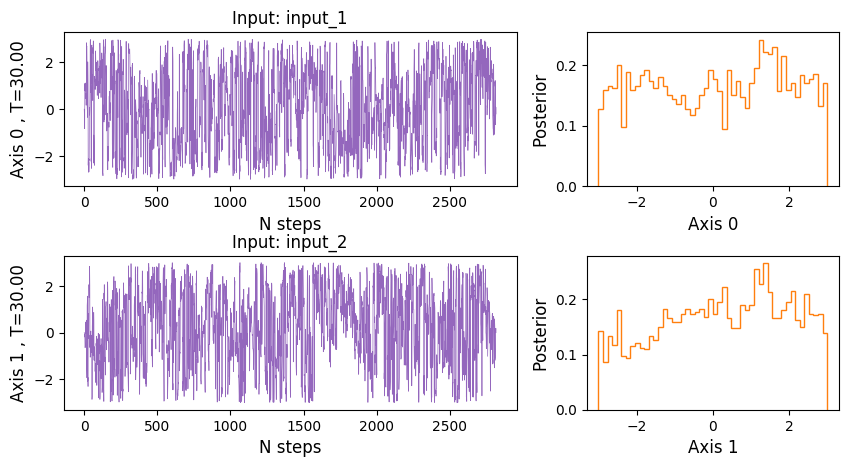

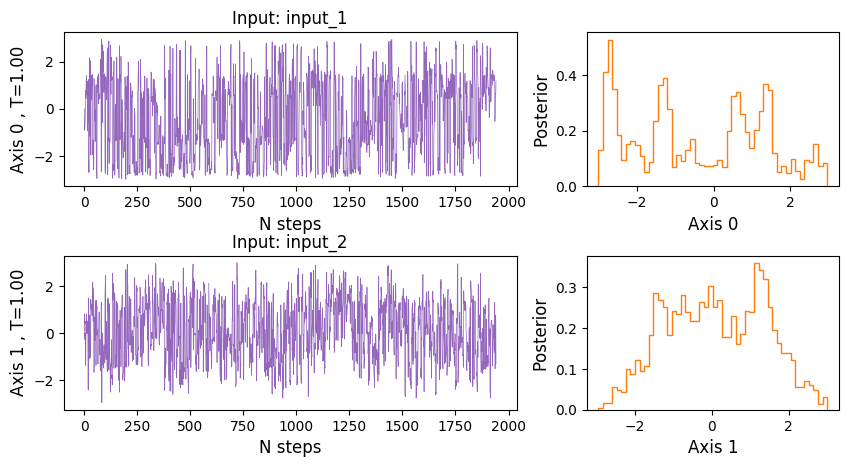

In [30]:
chain_steps, T_list = sampler_obj.run_PTMCMC( 30, 2500, [0,0], \
                            sampler_obj.classifier_target_dist,  \
                       "rbf",  alpha=0.4, c_spacing=1.5, verbose=True, trace_plots=True)

Once we have a posterior, we can under sample and obtain a desired number of new points.

Converging to 25 points, 10 times.
	 acc_pts: 25, Kappa = 166.666  *1*  11.17s
	 acc_pts: 25, Kappa = 164.048  *2*  23.94s
	 acc_pts: 25, Kappa = 165.655  *3*  26.49s
	 acc_pts: 25, Kappa = 157.261  *4*  55.15s
	 acc_pts: 25, Kappa = 144.977  *5*  58.29s
	 acc_pts: 25, Kappa = 150.834  *6*  61.10s
	 acc_pts: 25, Kappa = 159.151  *7*  77.01s
	 acc_pts: 25, Kappa = 153.823  *8*  89.01s
	 acc_pts: 25, Kappa = 156.603  *9*  93.58s
	 acc_pts: 25, Kappa = 160.892  *10*  102.80s

Final Kappa = 160.8916742667993

Average Distances: 
[2.77483119 2.80537081 2.92958669 2.76477072 2.92370289 2.91790151
 2.97993789 2.9659968  2.9835658  2.94555591]
Kappas: 
[166.66565609 164.04765052 165.6553175  157.2608547  144.97689482
 150.83396137 159.15088194 153.82330052 156.60265375 160.89167427]
loc: 8


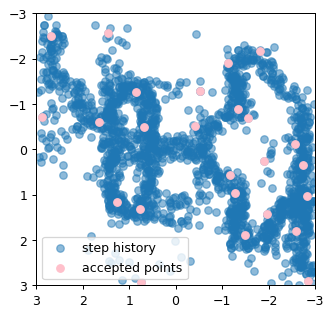

In [36]:
# get 20 new proposed points, start with a scaling factor kappa = ( 12.5 )**2
points, kapps = sampler_obj.get_proposed_points( 
                        chain_steps[len(T_list)-1], 25, 156.25, 
                        n_iters=10,
                        verbose=True)